In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-04-03 16:43:01.900930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 16:43:01.901063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 16:43:01.902783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 1. Positional Encodings

- Each word is represented as a fixed-length vector called an embedding.
- Since language is inherently positional, we add the positional information through the embeddings.

$$PE_{(pos, 2i)} = sin(pos / 10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = cos(pos / 10000^{2i/d_{model}})$$

Where:
- $pos$ is the absolute word position in the sentence.
- $d_{model}$ is the dimensionality of the embeddings.
- $i$ iterates from 0 to $\lfloor \frac{d_{model}}{2} \rfloor$, determining whether the positional encoding should apply $sin$ or $cos$ to each position within the sequence.

In [2]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """

    # initialize a matrix angle_rads of all the angles 
    angle_rads = np.arange(positions)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d)[np.newaxis, :]//2)) / np.float32(d))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

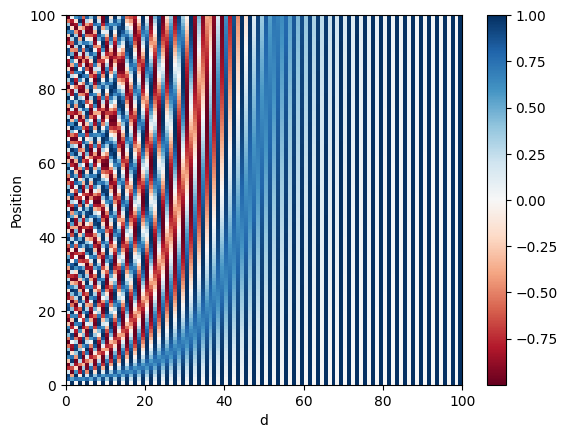

In [3]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 64
pos_encoding = positional_encoding(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, EMBEDDING_DIM))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### 1.1 Properties:
1. The norm is constant.
2. The norm of the difference between two vectors separated by $k$ is also constant.

Positional encodings keep the norm constant as a unit in a metric. The relative distance between two objects/embeddings MUST BE independent of their absolute position. In our universe, if each position were dependent on the (0, 0, 0) where the singularity occurred, equal relative distances would be different in different parts of the space !!! and thus we could not generalize the same problem in different parts of the space. This is closely related to the Principle of Relativity.

#### 1.2 Correlation

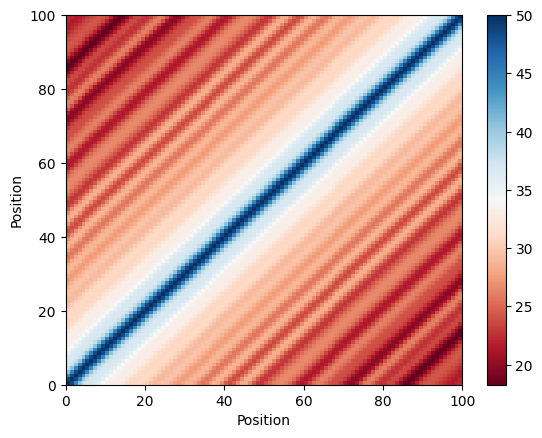

In [4]:
# Positional encoding correlation
corr = tf.matmul(pos_encoding, pos_encoding, transpose_b=True).numpy()[0]
plt.pcolormesh(corr, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### 1.3 Eucledian Distance

(100, 100)


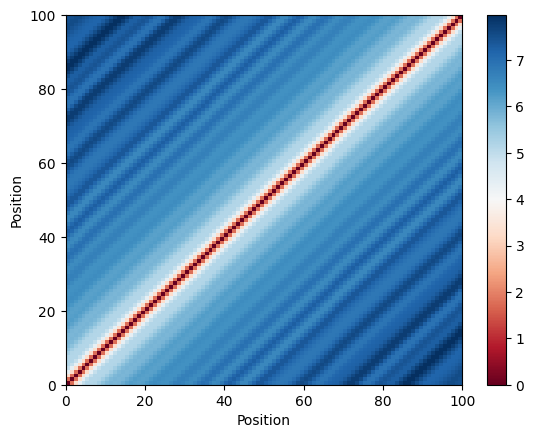

In [5]:
# Positional encoding euclidean distance
eu = np.zeros((MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH))
print(eu.shape)
for a in range(MAX_SEQUENCE_LENGTH):
    for b in range(a + 1, MAX_SEQUENCE_LENGTH):
        eu[a, b] = tf.norm(tf.math.subtract(pos_encoding[0, a], pos_encoding[0, b]))
        eu[b, a] = eu[a, b]
        
plt.pcolormesh(eu, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 2. Visualizing Embeddings with PCA
#### 2.1 Loading pre-trained embeddings

In [6]:
embeddings_index = {}
GLOVE_DIR = "/kaggle/input/glove-global-vectors-for-word-representation"
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print('d_model:', embeddings_index['hi'].shape)

Found 400000 word vectors.
d_model: (100,)


In [7]:
texts = ['king queen man woman dog wolf football basketball red green yellow',
         'man queen yellow basketball green dog  woman football  king red wolf']

#### 2.2 Tokenization and padding

In [8]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

print(data.shape)
print(data)

Found 11 unique tokens.
(2, 100)
[[ 1  2  3  4  5  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 3  2 11  8 10  5  4  7  1  9  6  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]


In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(12, 100)


In [10]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            trainable=False)

embedding = embedding_layer(data)
embedding.shape

TensorShape([2, 100, 100])

#### 2.3 Embeddings without Positional Encoding

In [11]:
from sklearn.decomposition import PCA

def plot_words(embedding, sequences, sentence, title):
    pca = PCA(n_components=2)
    X_pca_train = pca.fit_transform(embedding[sentence, 0:len(sequences[sentence]), :])

    plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1])
    words = list(word_index.keys())
    for i, index in enumerate(sequences[sentence]):
        plt.annotate(words[index-1], (X_pca_train[i, 0], X_pca_train[i, 1]))
    plt.title(title)

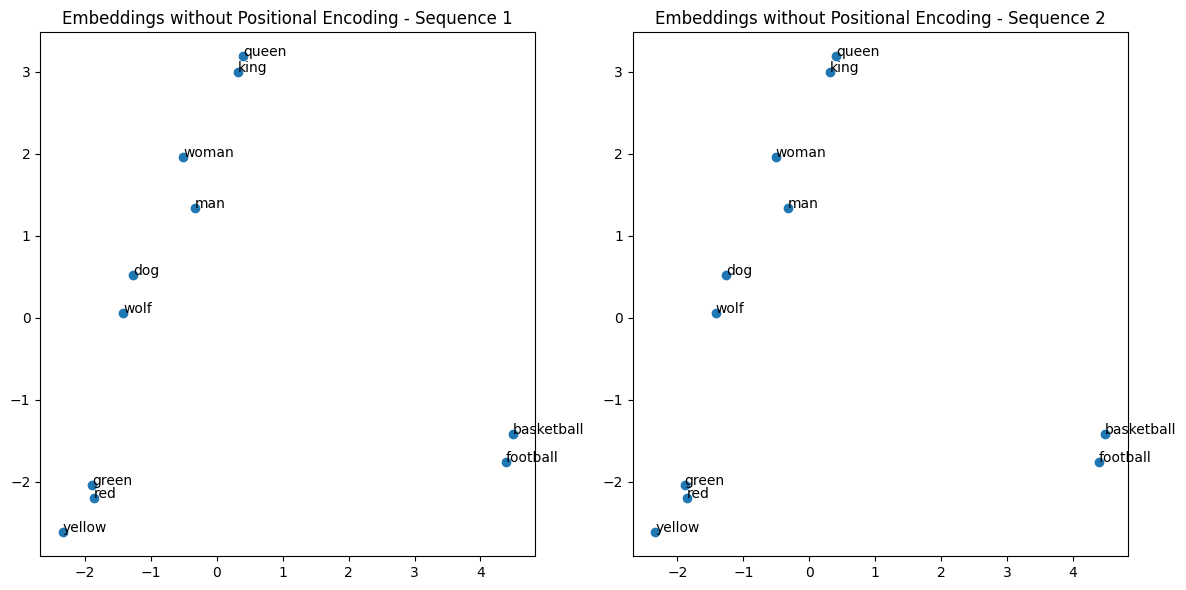

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_words(embedding, sequences, 0, 'Embeddings without Positional Encoding - Sequence 1')

plt.subplot(1, 2, 2)
plot_words(embedding, sequences, 1, 'Embeddings without Positional Encoding - Sequence 2')

plt.tight_layout()

#### 2.4 Embeddings with Positional Encoding

In [13]:
# Positional Embeddings
W1 = 1 # Change me
W2 = 10 # Change me
embedding2 = embedding * W1 + pos_encoding[:,:,:] * W2

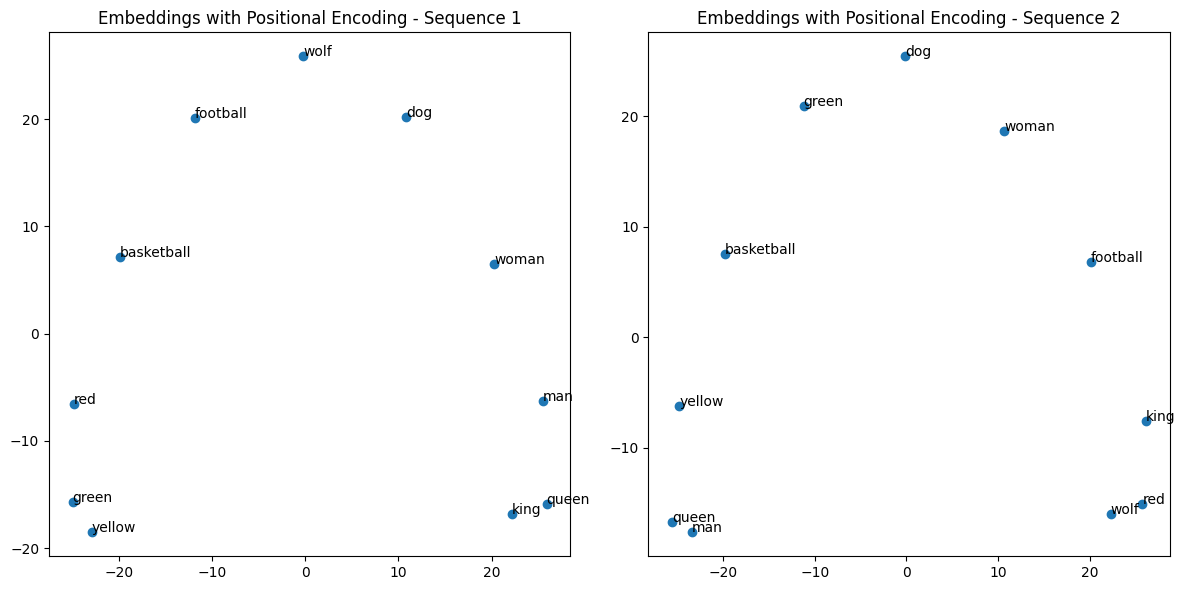

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_words(embedding2, sequences, 0, 'Embeddings with Positional Encoding - Sequence 1')

plt.subplot(1, 2, 2)
plot_words(embedding2, sequences, 1, 'Embeddings with Positional Encoding - Sequence 2')

plt.tight_layout()

#### What you should remember:
- Positional encodings can be expressed as linear functions of each other, which allow the model to learn according to the relative positions of words.
- Positional encodings can affect the word embeddings, but if the relative weight of the positional encoding is small, the sum will retain the semantic meaning of the words.

This notebook was inspired on the DeepLearning.AI course on Sequence Models.